# Setup

In [ ]:
!nvidia-smi -L

/bin/bash: nvidia-smi: command not found


In [ ]:
import plotly.io as pio
try:
    import google.colab
    print("Running as a Colab notebook")
    pio.renderers.default = "colab"
    %pip install transformer-lens fancy-einsum
    %pip install -U kaleido # kaleido only works if you restart the runtime. Required to write figures to disk (final cell)
except:
    print("Running as a Jupyter notebook")
    pio.renderers.default = "vscode"
    from IPython import get_ipython
    ipython = get_ipython()

Running as a Colab notebook
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 17.5 MB/s et

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install 'torchtyping'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from fancy_einsum import einsum
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils, ActivationCache
from torchtyping import TensorType as TT
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import einops
from typing import List, Union, Optional
from functools import partial
import pandas as pd
from pathlib import Path
import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm
from datasets import load_dataset
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://stackoverflow.com/q/62691279
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# model = HookedTransformer.from_pretrained(
#     "gpt2-large",
#     center_unembed=True,
#     center_writing_weights=True,
#     fold_ln=True,
#     refactor_factored_attn_matrices=True,
#     device=device,
# )

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    device=device,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


# Dot products of tokens after embedding layer

This uses gpt-2-large

In [ ]:
def dotprod_tokens(token_1, token_2):
    token_1_idx = model.to_single_token(token_1)
    token_2_idx = model.to_single_token(token_2)

    token_1_embedding = model.embed.W_E[token_1_idx]
    token_2_embedding = model.embed.W_E[token_2_idx]

    return torch.dot(token_1_embedding, token_2_embedding)

In [ ]:
token_1_idx = model.to_single_token(" large")
token_1_embedding = model.embed.W_E[token_1_idx]
token_1_embedding.shape

torch.Size([768])

In [ ]:
model.embed.W_E.shape

torch.Size([50257, 768])

Embedding is vocab size x d_model = 50257 x 768. So for one token, it's 1 x 768.

## large

In [ ]:
dotprod_tokens(" large", " huge")

tensor(0.6372, device='cuda:0')

In [ ]:
dotprod_tokens("large", "huge")

tensor(1.8710, device='cuda:0')

In [ ]:
dotprod_tokens("large", "small")

tensor(2.1379, device='cuda:0')

In [ ]:
dotprod_tokens("large", "red")

tensor(0.7302, device='cuda:0')

In [ ]:
dotprod_tokens(" large", " red")

tensor(0.2255, device='cuda:0')

In [ ]:
dotprod_tokens(" large", "large")

tensor(1.2888, device='cuda:0')

In [ ]:
dotprod_tokens(" large", " large")

tensor(1.8631, device='cuda:0')

In [ ]:
dotprod_tokens("large", "large")

tensor(3.9435, device='cuda:0')

Without spaces in front gives higher dot product

In [ ]:
dotprod_tokens("large", "concept")

tensor(0.7924, device='cuda:0')

In [ ]:
dotprod_tokens("large", "wine")

tensor(0.8100, device='cuda:0')

In [ ]:
dotprod_tokens("large", "horse")

tensor(0.8864, device='cuda:0')

In [ ]:
dotprod_tokens("large", "food")

tensor(0.8832, device='cuda:0')

In [ ]:
dotprod_tokens("large", "sleep")

tensor(0.8345, device='cuda:0')

In [ ]:
dotprod_tokens("large", "tall")

tensor(1.4606, device='cuda:0')

## tokens in general

In [ ]:
dotprod_tokens("bird", "tall")

tensor(0.6739, device='cuda:0')

In [ ]:
dotprod_tokens("bird", "concept")

tensor(0.8100, device='cuda:0')

## average over dataset of single tokens

In [ ]:
import random
import nltk

def generate_random_tokens(num_words):
    # Download the CMU Pronouncing Dictionary if not already downloaded
    nltk.download('cmudict')

    # Load the CMU Pronouncing Dictionary
    cmudict = nltk.corpus.cmudict.dict()

    rand_tokens = []
    while len(rand_tokens) < num_words:
        word = random.choice(list(cmudict.keys()))
        try:
            token = model.to_single_token(word)
            rand_tokens.append(word.lower())
        except:
            continue

        # If all available one-syllable words have been exhausted
        if len(rand_tokens) == len(cmudict.keys()):
            print("Warning: Insufficient one-syllable words in the CMU Pronouncing Dictionary.")
            break

    return rand_tokens

num_words = 100
rand_tokens = generate_random_tokens(num_words)

# Print the generated words
for word in rand_tokens[:10]:
    print(word)

In [ ]:
def compute_average_dot_product(tokens, model):
    num_tokens = len(tokens)
    dot_product_sum = 0
    num_pairs = 0
    for i in range(num_tokens):
        for j in range(i + 1, num_tokens):
            dot_product = dotprod_tokens(tokens[i], tokens[j])
            dot_product_sum += dot_product
            num_pairs += 1
    average_dot_product = dot_product_sum / num_pairs
    return average_dot_product

# Compute the average dot product
average_dot_product = compute_average_dot_product(rand_tokens, model)
print(average_dot_product)

tensor(0.7663, device='cuda:0')


In [ ]:
import matplotlib.pyplot as plt

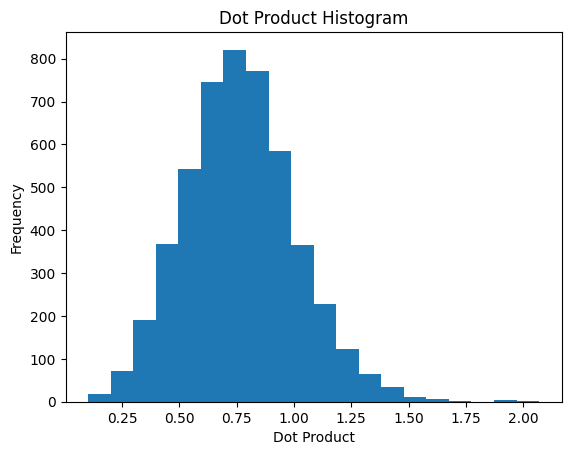

In [ ]:
dot_products = []
for i in range(len(rand_tokens)):
    for j in range(i + 1, len(rand_tokens)):
        dot_product = dotprod_tokens(rand_tokens[i], rand_tokens[j])
        dot_products.append(dot_product.item())

plt.hist(dot_products, bins=20)
plt.xlabel('Dot Product')
plt.ylabel('Frequency')
plt.title('Dot Product Histogram')
plt.show()

## For multiple tokens for a word, get the average of each token's embeddings

In [ ]:
model.to_tokens("enormous")

tensor([[50256,   268,   579,   516]], device='cuda:0')

In [ ]:
embeddings = model.embed.W_E[model.to_tokens("enormous")]
embeddings.shape

torch.Size([1, 4, 1280])

In [ ]:
mean_emb = torch.mean(model.embed.W_E[model.to_tokens("enormous")], dim=1)
mean_emb.shape

torch.Size([1, 1280])

In [ ]:
mean_emb[0].shape

torch.Size([1280])

In [ ]:
def generate_random_tokens(num_words):
    # Download the CMU Pronouncing Dictionary if not already downloaded
    nltk.download('cmudict')
    # Load the CMU Pronouncing Dictionary
    cmudict = nltk.corpus.cmudict.dict()
    rand_tokens = []
    while len(rand_tokens) < num_words:
        word = random.choice(list(cmudict.keys()))
        rand_tokens.append(word)
    return rand_tokens

num_words = 100
rand_tokens = generate_random_tokens(num_words)

# Print the generated words
for word in rand_tokens:
    print(word)

In [ ]:
def compute_dot_product(token_1, token_2, model):
    token_1_embedding = torch.mean(model.embed.W_E[model.to_tokens(token_1)], dim=1)[0]
    token_2_embedding = torch.mean(model.embed.W_E[model.to_tokens(token_2)], dim=1)[0]
    dot_product = torch.dot(token_1_embedding, token_2_embedding)
    return dot_product

In [ ]:
def compute_average_dot_product(tokens, model):
    num_tokens = len(tokens)
    dot_product_sum = 0
    num_pairs = 0
    for i in range(num_tokens):
        for j in range(i + 1, num_tokens):
            dot_product = compute_dot_product(tokens[i], tokens[j], model)
            dot_product_sum += dot_product
            num_pairs += 1
    average_dot_product = dot_product_sum / num_pairs
    return average_dot_product

# Compute the average dot product
average_dot_product = compute_average_dot_product(rand_tokens, model)
print(average_dot_product)

tensor(0.4076, device='cuda:0')


## Dot Product of large synonyms

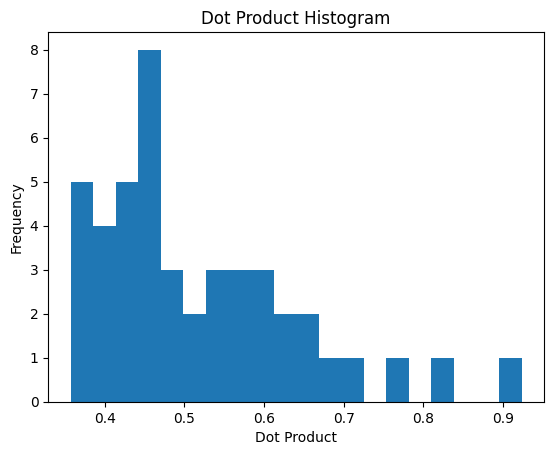

In [ ]:
synonyms_large = ["big", "huge", "enormous", "massive", "gigantic", "immense", "vast", "substantial", "grand", "colossal"]

dot_products = []
for i in range(len(synonyms_large)):
    for j in range(i + 1, len(synonyms_large)):
        dot_product = compute_dot_product(synonyms_large[i], synonyms_large[j], model)
        dot_products.append(dot_product.item())

# Generate histogram of dot products
plt.hist(dot_products, bins=20)
plt.xlabel('Dot Product')
plt.ylabel('Frequency')
plt.title('Dot Product Histogram')
plt.show()


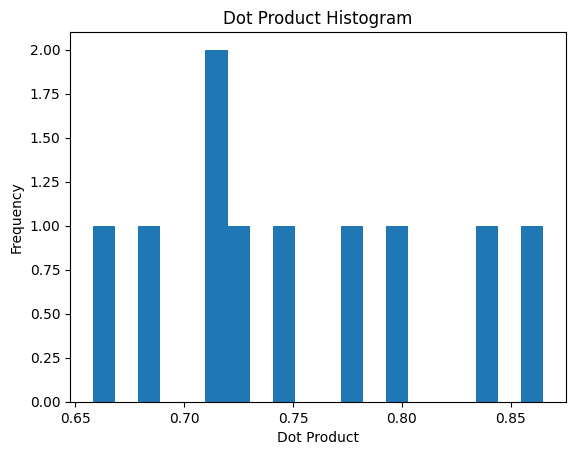

In [ ]:
# Try one syllable only

synonyms_large = ["large", "big", "huge", "grand", "tall"]

dot_products = []
for i in range(len(synonyms_large)):
    for j in range(i + 1, len(synonyms_large)):
        dot_product = compute_dot_product(synonyms_large[i], synonyms_large[j], model)
        dot_products.append(dot_product.item())

# Generate histogram of dot products
plt.hist(dot_products, bins=20)
plt.xlabel('Dot Product')
plt.ylabel('Frequency')
plt.title('Dot Product Histogram')
plt.show()

In [ ]:
dot_products = []
for i in range(len(synonyms_large)):
    for j in range(i + 1, len(synonyms_large)):
        dot_product = compute_dot_product(synonyms_large[i], synonyms_large[j], model)
        dot_products.append((dot_product.item(), synonyms_large[i], synonyms_large[j]))

dot_products

[(0.801905632019043, 'large', 'big'),
 (0.8649396300315857, 'large', 'huge'),
 (0.6885147094726562, 'large', 'grand'),
 (0.7752034664154053, 'large', 'tall'),
 (0.8366391658782959, 'big', 'huge'),
 (0.7171421051025391, 'big', 'grand'),
 (0.7435740828514099, 'big', 'tall'),
 (0.6579955816268921, 'huge', 'grand'),
 (0.7165335416793823, 'huge', 'tall'),
 (0.7267042398452759, 'grand', 'tall')]

# Dot products of token and all neurons (congruence)

We define congruence as this dot product

In [ ]:
tokens_of_interest_strs = ["large"]
tokens_of_interest = torch.tensor([model.to_single_token(token_str) for token_str in tokens_of_interest_strs], device=device)
tokens_of_interest[0]

tensor(11664, device='cuda:0')

In [ ]:
def get_congr_token_noplot(token):
    tokens_of_interest_strs = [token]
    tokens_of_interest = torch.tensor([model.to_single_token(token_str) for token_str in tokens_of_interest_strs], device=device)

    mlp_output_weights = torch.cat([block.mlp.W_out for block in model.blocks], dim=0)# (n_layer * d_mlp, d_model)

    token_of_interest_dot_product = torch.einsum("d, nd -> n", model.embed.W_E[tokens_of_interest[0]], mlp_output_weights)
    return token_of_interest_dot_product

In [ ]:
get_congr_token_noplot("large")

tensor([-0.0951, -0.0950,  0.0379,  ..., -0.2625, -0.1847,  0.1657],
       device='cuda:0')

In [ ]:
torch.einsum("d, nd -> n", model.embed.W_E[tokens_of_interest[0]], mlp_output_weights)

get_congr_token_noplot("large")

In [ ]:
dot_product_large = get_congr_token_noplot("large")
dot_product_tall = get_congr_token_noplot("tall")

# Calculate the dot product between the two outputs' congruence (congruence similarity)
dot_product_of_outputs = torch.dot(dot_product_large, dot_product_tall)
print(dot_product_of_outputs)

tensor(1316.4133, device='cuda:0')


In [ ]:
dot_product_large = get_congr_token_noplot("large")
dot_product_tall = get_congr_token_noplot("big")

# Calculate the dot product between the two outputs
dot_product_of_outputs = torch.dot(dot_product_large, dot_product_tall)
print(dot_product_of_outputs)

tensor(1312.7552, device='cuda:0')


In [ ]:
dot_product_large = get_congr_token_noplot("large")
dot_product_tall = get_congr_token_noplot("red")

# Calculate the dot product between the two outputs
dot_product_of_outputs = torch.dot(dot_product_large, dot_product_tall)
print(dot_product_of_outputs)

tensor(751.1814, device='cuda:0')


In [ ]:
dot_product_large = get_congr_token_noplot("red")
dot_product_tall = get_congr_token_noplot("horse")

# Calculate the dot product between the two outputs
dot_product_of_outputs = torch.dot(dot_product_large, dot_product_tall)
print(dot_product_of_outputs)

tensor(596.4404, device='cuda:0')


Next, run get_congr_token_noplot() on random words and get the histogram

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


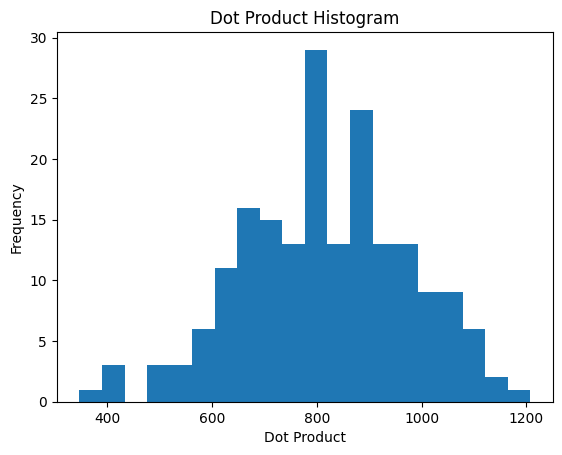

In [ ]:
dot_products = []
for i in range(len(rand_tokens[0:20])):
    for j in range(i + 1, len(rand_tokens[0:20])):
        dot_product = torch.dot(get_congr_token_noplot(rand_tokens[i]), get_congr_token_noplot(rand_tokens[j]))
        dot_products.append(dot_product.item())
    print(i)

plt.hist(dot_products, bins=20)
plt.xlabel('Dot Product')
plt.ylabel('Frequency')
plt.title('Dot Product Histogram')
plt.show()

This plot gets the dot product of all pairs of N*T, where N is the matrix of all neurons (rows) and their output weights (cols).

We see that the dot product of large and tall for all neurons (after passing through the entire model, basically) is higher with each other than the typical average. This shows that the neurons typically find some "similarity" between the two tokens.

If we isolate the neurons with the biggest impact, and only take the dot prod of tokens with those neurons, this similarity is prob even bigger.

### Compute dot products for "tall" and "large", and compare the similarities (eg. which are in the top) AND identify their common top neurons

In [ ]:
def get_congr_token(token):
    tokens_of_interest_strs = [token]
    tokens_of_interest = torch.tensor([model.to_single_token(token_str) for token_str in tokens_of_interest_strs], device=device)

    mlp_output_weights = torch.cat([block.mlp.W_out for block in model.blocks], dim=0)# (n_layer * d_mlp, d_model)

    congruence_list = []

    for i, token_of_interest_str in enumerate(tokens_of_interest_strs[:1]):
        token_of_interest_dot_product = torch.einsum("d, nd -> n", model.embed.W_E[tokens_of_interest[i]], mlp_output_weights)
        for j in range(mlp_output_weights.shape[0]):
            layer_index = j // model.cfg.d_mlp
            neuron_index = j % model.cfg.d_mlp
            dot_product = token_of_interest_dot_product[j].item()
            congruence_list.append((layer_index, neuron_index, dot_product))

    # Sorting the list based on the dot product value in descending order
    congruence_list.sort(key=lambda x: x[2], reverse=True)

    return congruence_list

# Call the function and print the top 10 results
congruence_list = get_congr_token("large")
for layer, neuron, dot_product in congruence_list[:10]:
    print(f"Layer: {layer}, Neuron: {neuron}, Dot product: {dot_product}")


Layer: 35, Neuron: 3354, Dot product: 2.6526758670806885
Layer: 35, Neuron: 2513, Dot product: 2.5238125324249268
Layer: 35, Neuron: 4295, Dot product: 2.4259932041168213
Layer: 35, Neuron: 3552, Dot product: 2.068981885910034
Layer: 35, Neuron: 1258, Dot product: 2.0455541610717773
Layer: 35, Neuron: 4646, Dot product: 2.0359530448913574
Layer: 34, Neuron: 2073, Dot product: 2.012631416320801
Layer: 35, Neuron: 1152, Dot product: 1.989741563796997
Layer: 35, Neuron: 363, Dot product: 1.9761250019073486
Layer: 35, Neuron: 1895, Dot product: 1.9626986980438232


In [ ]:
# Call the function and print the top 10 results
congruence_list = get_congr_token("tall")
for layer, neuron, dot_product in congruence_list[:10]:
    print(f"Layer: {layer}, Neuron: {neuron}, Dot product: {dot_product}")

Layer: 35, Neuron: 3354, Dot product: 3.19109845161438
Layer: 35, Neuron: 2513, Dot product: 2.907909393310547
Layer: 35, Neuron: 4295, Dot product: 2.818138360977173
Layer: 35, Neuron: 3552, Dot product: 2.7492282390594482
Layer: 34, Neuron: 2073, Dot product: 2.613084316253662
Layer: 35, Neuron: 363, Dot product: 2.519033432006836
Layer: 35, Neuron: 2819, Dot product: 2.436403274536133
Layer: 35, Neuron: 1152, Dot product: 2.378448724746704
Layer: 35, Neuron: 1258, Dot product: 2.3476874828338623
Layer: 35, Neuron: 1895, Dot product: 2.3344461917877197


In [ ]:
# Call the function and print the top 10 results
congruence_list = get_congr_token("red")
for layer, neuron, dot_product in congruence_list[:10]:
    print(f"Layer: {layer}, Neuron: {neuron}, Dot product: {dot_product}")

Layer: 35, Neuron: 5112, Dot product: 1.7295725345611572
Layer: 35, Neuron: 3354, Dot product: 1.421290397644043
Layer: 35, Neuron: 3552, Dot product: 1.3636834621429443
Layer: 35, Neuron: 2513, Dot product: 1.3432565927505493
Layer: 32, Neuron: 366, Dot product: 1.3420734405517578
Layer: 35, Neuron: 4295, Dot product: 1.2424718141555786
Layer: 29, Neuron: 2768, Dot product: 1.2369710206985474
Layer: 26, Neuron: 1887, Dot product: 1.192339539527893
Layer: 35, Neuron: 363, Dot product: 1.1591509580612183
Layer: 35, Neuron: 1336, Dot product: 1.1445176601409912


# Dot products of input after first MLP layer

In [ ]:
def get_logits(input_text, model):
    input_tokens = model.tokenizer.encode(input_text, add_special_tokens=True)
    input_tensor = torch.tensor(input_tokens).unsqueeze(0)  # Adding batch dimension
    outputs = model(input_tensor)
    return outputs

input_text = "large"
intermediate_embeddings = get_interm_embed(input_text, model)
print(intermediate_embeddings.shape)

torch.Size([1, 1, 50257])


In [ ]:
input_text = "huge"
intermediate_embeddings_2 = get_interm_embed(input_text, model)
print(intermediate_embeddings_2)

tensor([[[ 5.0742,  6.2680,  2.9993,  ..., -0.7970, -1.2818,  4.6927]]],
       grad_fn=<AddBackward0>)


In [ ]:
torch.dot(intermediate_embeddings, intermediate_embeddings_2)

RuntimeError: ignored

In [ ]:
# Assuming intermediate_embeddings and intermediate_embeddings_2 are 3D tensors
# with shapes (batch_size, sequence_length, embedding_size)

# Compute the dot product along the last dimension (embedding_size)
dot_product = torch.matmul(intermediate_embeddings, intermediate_embeddings_2.transpose(1, 2))
dot_product

tensor([[[81807.3594]]], grad_fn=<UnsafeViewBackward0>)

In [ ]:
def get_interm_embed(tokens, model):
    input_tokens = model.tokenizer.encode(input_text, add_special_tokens=True)
    input_tensor = torch.tensor(input_tokens).unsqueeze(0)  # Adding batch dimension

    cache = {}  # Create a dictionary to store intermediate outputs
    model.cache_some(cache, lambda x: x == "blocks.0.hook_resid_post") #  Hook into the desired layer to capture intermediate output
    model(tokens)
    intermediate_embeddings = model.blocks[1].attn.ln1(cache["blocks.0.hook_resid_post"])

    return intermediate_embeddings

In [ ]:
input_text = "large"
intermediate_embeddings = get_interm_embed(input_text, model)
input_text = "huge"
intermediate_embeddings_2 = get_interm_embed(input_text, model)

dot_product = torch.matmul(intermediate_embeddings, intermediate_embeddings_2.transpose(1, 2))
dot_product

tensor([[[768.0000, 182.4072],
         [164.7558, 647.2665]]])

In [ ]:
torch.dot(intermediate_embeddings, intermediate_embeddings_2)

RuntimeError: ignored

In [ ]:
intermediate_embeddings.shape

torch.Size([1, 2, 768])

Why output after 1st embed gets scalar, this isn't?